In [52]:
# Importando librerias necesarias
import os
import json
import cv2 as cv
import numpy as np
import networkx as nx

from skimage import morphology
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import approximate_polygon

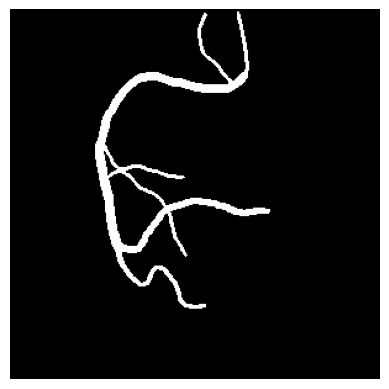

In [53]:
image_path_mo = 'images/1_gt.pgm'
imagen_color_mo = cv.imread(image_path_mo)
imagen_gris_mo = cv.cvtColor(imagen_color_mo, cv.COLOR_BGR2GRAY)
_, binary_image_mo = cv.threshold(imagen_gris_mo, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

plt.imshow(binary_image_mo, cmap='gray')
plt.axis('off')
plt.show()

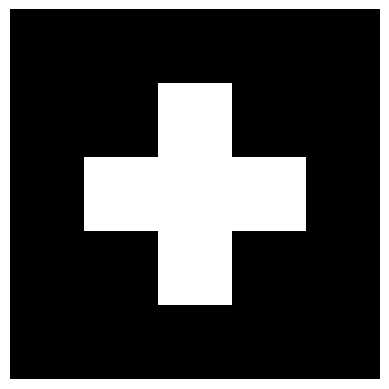

In [54]:
def cross(radius): 
    se = cv.getStructuringElement(cv.MORPH_CROSS, (radius, radius))
    return np.pad(se, 1, mode='constant', constant_values=0)
    

radius = 3
plt.imshow(cross(radius), cmap='gray')
plt.axis('off')
plt.show()

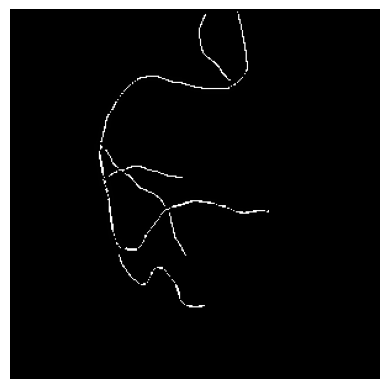

In [55]:

binary_img_copy_mo = binary_image_mo.copy()
skeleton_mo = np.zeros(binary_img_copy_mo.shape).astype(np.uint8)

flag = True
while flag:

    radius = 3
    cross_mo = cross(radius)
    cross_opening_mo = morphology.opening(binary_img_copy_mo, cross_mo)
    ceoss_dilation_mo = morphology.dilation(cross_opening_mo, cross_mo)

    img_subtraction_mo = binary_img_copy_mo - ceoss_dilation_mo
    skeleton_mo += img_subtraction_mo
    
    cross_erosion_mo = morphology.erosion(binary_img_copy_mo, cross_mo)
    binary_img_copy_mo = cross_erosion_mo

    if np.sum(binary_img_copy_mo) == 0: flag = False

plt.imshow(skeleton_mo, cmap='gray')
plt.axis('off')
plt.show()

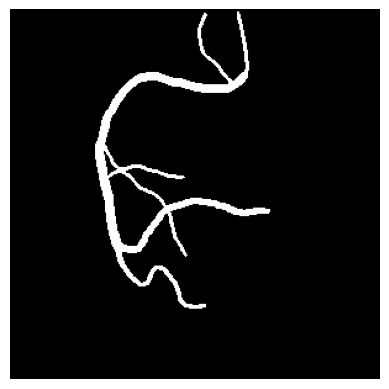

In [304]:
image_path = 'images/1_gt.pgm'
imagen_color = cv.imread(image_path)
imagen_gris = cv.cvtColor(imagen_color, cv.COLOR_BGR2GRAY)
_, binary_image = cv.threshold(imagen_gris, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.show()

# Esqueletización de la figura

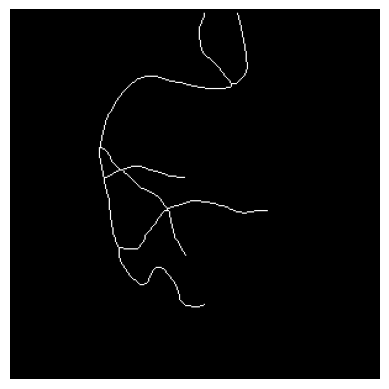

In [305]:
skeleton = skeletonize(binary_image)
plt.imshow(skeleton, cmap='gray')
plt.axis('off')
plt.show()

## Recolectando todos los nodos

In [306]:
all_nodes_list = []
for i in range(1, skeleton.shape[0] - 1):
    for j in range(1, skeleton.shape[1] - 1):
        if skeleton[i, j]: all_nodes_list.append((i, j))

all_nodes_list = np.array(all_nodes_list)
all_nodes_list

array([[  3, 157],
       [  3, 184],
       [  4, 157],
       ...,
       [241, 151],
       [241, 152],
       [241, 153]])

## Generando lista de nodos extremos

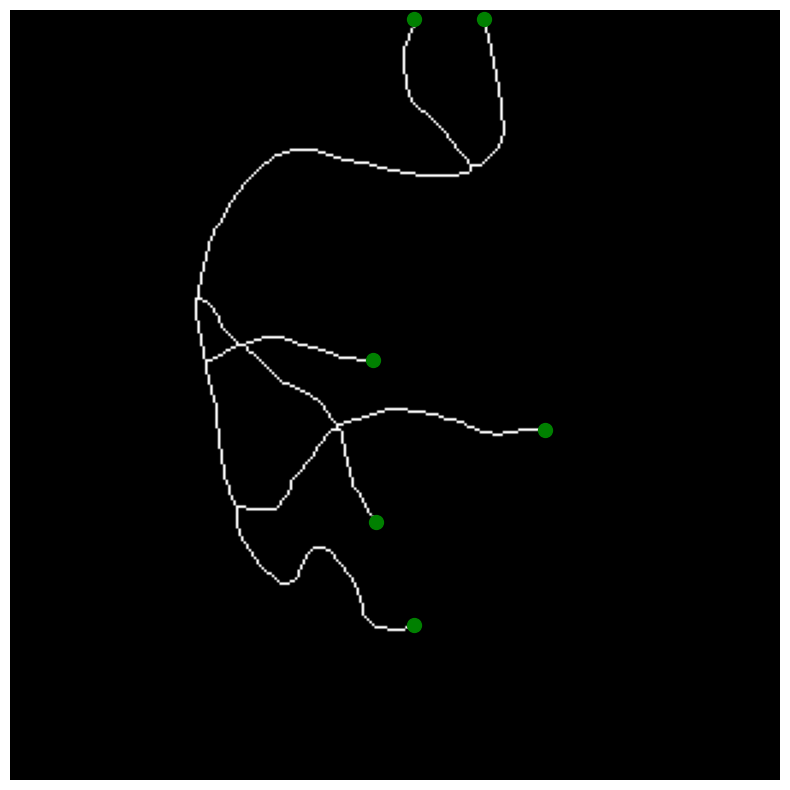

In [307]:
extreme_nodes_list = []
for i in range(1, skeleton.shape[0] - 1):
    for j in range(1, skeleton.shape[1] - 1):
        if skeleton[i, j]:
            rows, columns = np.ogrid[i-1:i+2, j-1:j+2]
            if np.sum(skeleton[rows, columns]) == 2:
                extreme_nodes_list.append((i, j))


plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in extreme_nodes_list], 
         [node[0] for node in extreme_nodes_list], 
         'go',
          markersize=10)

plt.axis('off')
plt.show()

## Generando lista de nodos intermedios

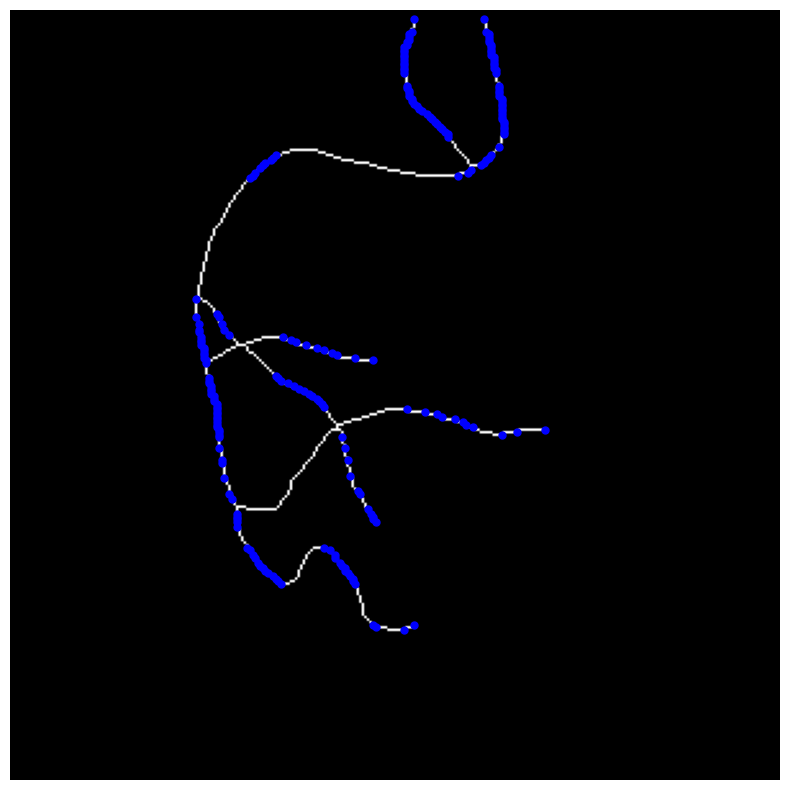

In [308]:
tolerance = 5
intermediate_nodes = approximate_polygon(all_nodes_list, tolerance)

plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in intermediate_nodes], 
         [node[0] for node in intermediate_nodes], 
         'o',
         color='blue',
         markersize=5)
plt.axis('off')
plt.show()

## Generando listas de bifurcaciones y trifurcaciones

In [309]:
# Bifurcaciones y Trifurcaciones

# Bifurcation - Nodo con 3 vecinos
# Trifurcation - Nodo con 4 vecinos

bifurcation_nodes_list = []
trifurcation_nodes_list = []

for i in range(1, skeleton.shape[0] - 1):
		for j in range(1, skeleton.shape[1] - 1):
				if skeleton[i, j]:
						# Check if is not already in either list
						right = skeleton[i, j+1] and (i, j+1) not in bifurcation_nodes_list and (i, j+1) not in trifurcation_nodes_list
						left = skeleton[i, j-1] and (i, j-1) not in bifurcation_nodes_list and (i, j-1) not in trifurcation_nodes_list
						up = skeleton[i-1, j] and (i-1, j) not in bifurcation_nodes_list and (i-1, j) not in trifurcation_nodes_list
						down = skeleton[i+1, j] and (i+1, j) not in bifurcation_nodes_list and (i+1, j) not in trifurcation_nodes_list
						upper_left = skeleton[i-1, j-1] and (i-1, j-1) not in bifurcation_nodes_list and (i-1, j-1) not in trifurcation_nodes_list
						upper_right = skeleton[i-1, j+1] and (i-1, j+1) not in bifurcation_nodes_list and (i-1, j+1) not in trifurcation_nodes_list
						lower_left = skeleton[i+1, j-1] and (i+1, j-1) not in bifurcation_nodes_list and (i+1, j-1) not in trifurcation_nodes_list
						lower_right = skeleton[i+1, j+1] and (i+1, j+1) not in bifurcation_nodes_list and (i+1, j+1) not in trifurcation_nodes_list
						neighbors = [right, left, up, down, upper_left, upper_right, lower_left, lower_right]
						neighbors_sum = np.sum(neighbors)
						# Trifurcation has higher priority
						if neighbors_sum == 4:
								trifurcation_nodes_list.append((i, j))
						elif neighbors_sum == 3:
								bifurcation_nodes_list.append((i, j))
						


### Mostrando biburcaciones

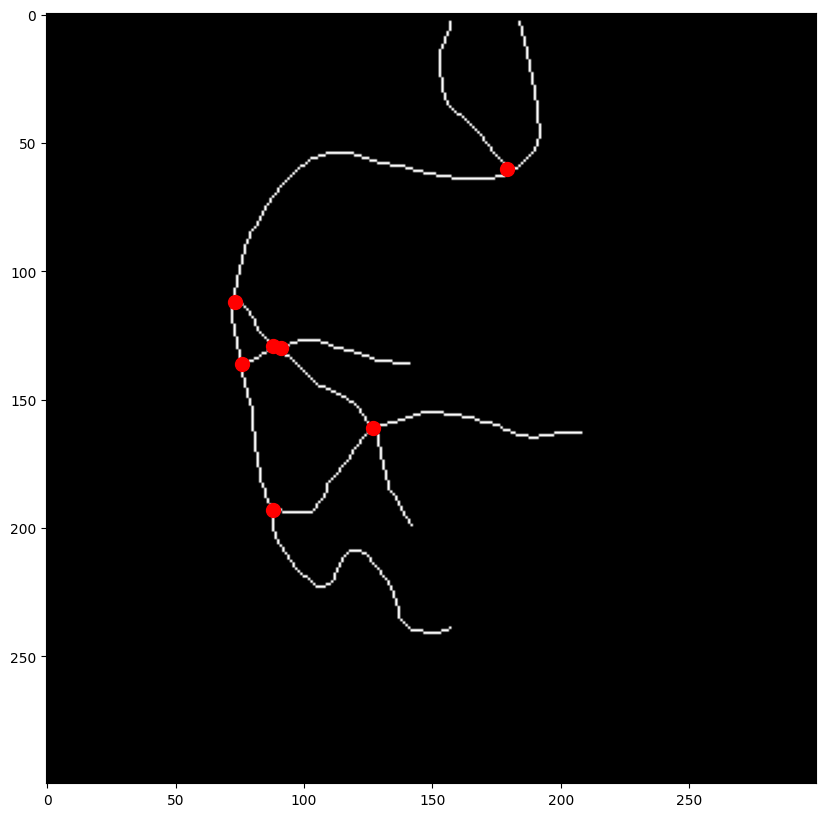

In [310]:
plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in bifurcation_nodes_list], 
				 [node[0] for node in bifurcation_nodes_list], 
				 'ro',
					markersize=10)

### Imagen original Vs. Imagen con bifurcaciones, trifurcaciones y nodos extremos

(-0.5, 299.5, 299.5, -0.5)

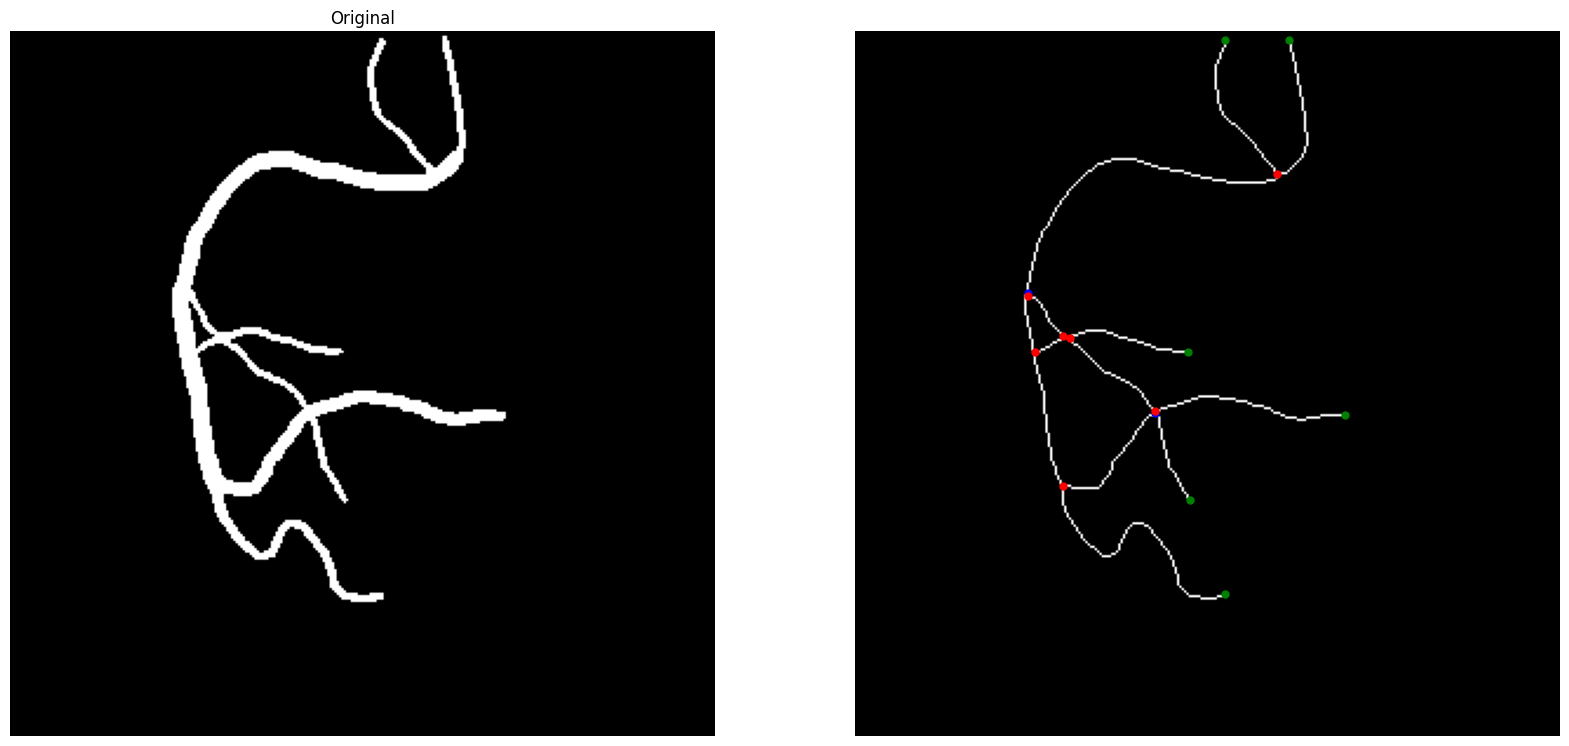

In [311]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(imagen_color)
plt.axis('off')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(skeleton, cmap='gray')

plt.plot([node[1] for node in trifurcation_nodes_list], 
				 [node[0] for node in trifurcation_nodes_list], 
				 'bo',
					markersize=5)
plt.plot([node[1] for node in bifurcation_nodes_list], 
				 [node[0] for node in bifurcation_nodes_list], 
				 'ro',
					markersize=5)

plt.plot([node[1] for node in extreme_nodes_list], 
         [node[0] for node in extreme_nodes_list], 
         'go',
          markersize=5)

plt.axis('off')



In [312]:
def get_image_features(image_path, json_data=False):
		imagen_color = cv.imread(image_path)
		imagen_gris = cv.cvtColor(imagen_color, cv.COLOR_BGR2GRAY)
		_, binary_image = cv.threshold(imagen_gris, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
		skeleton = skeletonize(binary_image)
		
		all_nodes_list = []
		for i in range(1, skeleton.shape[0] - 1):
				for j in range(1, skeleton.shape[1] - 1):
						if skeleton[i, j]: all_nodes_list.append((i, j))

		all_nodes_list = np.array(all_nodes_list)
		extreme_nodes_list = []
		for i in range(1, skeleton.shape[0] - 1):
				for j in range(1, skeleton.shape[1] - 1):
						if skeleton[i, j]:
								rows, columns = np.ogrid[i-1:i+2, j-1:j+2]
								if np.sum(skeleton[rows, columns]) == 2:
										extreme_nodes_list.append((i, j))

		tolerance = 4
		intermediate_nodes = approximate_polygon(all_nodes_list, tolerance)

		bifurcation_nodes_list = []
		trifurcation_nodes_list = []

		for i in range(1, skeleton.shape[0] - 1):
				for j in range(1, skeleton.shape[1] - 1):
						if skeleton[i, j]:
								right = skeleton[i, j+1] and (i, j+1) not in bifurcation_nodes_list and (i, j+1) not in trifurcation_nodes_list
								left = skeleton[i, j-1] and (i, j-1) not in bifurcation_nodes_list and (i, j-1) not in trifurcation_nodes_list
								up = skeleton[i-1, j] and (i-1, j) not in bifurcation_nodes_list and (i-1, j) not in trifurcation_nodes_list
								down = skeleton[i+1, j] and (i+1, j) not in bifurcation_nodes_list and (i+1, j) not in trifurcation_nodes_list
								upper_left = skeleton[i-1, j-1] and (i-1, j-1) not in bifurcation_nodes_list and (i-1, j-1) not in trifurcation_nodes_list
								upper_right = skeleton[i-1, j+1] and (i-1, j+1) not in bifurcation_nodes_list and (i-1, j+1) not in trifurcation_nodes_list
								lower_left = skeleton[i+1, j-1] and (i+1, j-1) not in bifurcation_nodes_list and (i+1, j-1) not in trifurcation_nodes_list
								lower_right = skeleton[i+1, j+1] and (i+1, j+1) not in bifurcation_nodes_list and (i+1, j+1) not in trifurcation_nodes_list
								neighbors = [right, left, up, down, upper_left, upper_right, lower_left, lower_right]
								neighbors_sum = np.sum(neighbors)
								if neighbors_sum == 4:
										trifurcation_nodes_list.append((i, j))
										trifurcation_nodes_list.append((i + 1, j))
										trifurcation_nodes_list.append((i - 1, j))
										trifurcation_nodes_list.append((i, j + 1))
										trifurcation_nodes_list.append((i, j - 1))
										trifurcation_nodes_list.append((i + 1, j + 1))
										trifurcation_nodes_list.append((i - 1, j - 1))
										trifurcation_nodes_list.append((i + 1, j - 1))
										trifurcation_nodes_list.append((i - 1, j + 1))
								elif neighbors_sum == 3:
										bifurcation_nodes_list.append((i, j))
										bifurcation_nodes_list.append((i + 1, j))
										bifurcation_nodes_list.append((i - 1, j))
										bifurcation_nodes_list.append((i, j + 1))
										bifurcation_nodes_list.append((i, j - 1))
										bifurcation_nodes_list.append((i + 1, j + 1))
										bifurcation_nodes_list.append((i - 1, j - 1))
										bifurcation_nodes_list.append((i + 1, j - 1))
										bifurcation_nodes_list.append((i - 1, j + 1))

		name = (image_path.split('/')[-1])[:-4]
		
		return skeleton, bifurcation_nodes_list, trifurcation_nodes_list, extreme_nodes_list, intermediate_nodes, name, all_nodes_list, binary_image

# PathFinding 
Se utiliza pathfinding para generar las aristas.

In [313]:
def check_availability(extremes, bif_nodes, trif_nodes):
        if len(extremes) and len(bif_nodes) and len(trif_nodes):
            feature_nodes_list = np.concatenate((extremes, bif_nodes, trif_nodes)).tolist()

        elif len(extremes) and len(bif_nodes):
            feature_nodes_list = np.concatenate((extremes, bif_nodes)).tolist()
        elif len(extremes) and len(trif_nodes):
            feature_nodes_list = np.concatenate((extremes, trif_nodes)).tolist()
        elif len(bif_nodes) and len(trif_nodes):
            feature_nodes_list = np.concatenate((bif_nodes, trif_nodes)).tolist()

        elif len(extremes):
            feature_nodes_list = extremes
        elif len(bif_nodes):
            feature_nodes_list = bif_nodes
        elif len(trif_nodes):
            feature_nodes_list = trif_nodes

        return feature_nodes_list

In [314]:
def get_edges(skeleton, extreme_nodes_list, bifurcation_nodes_list, trifurcation_nodes_list, intermediate_nodes):

	skeleton_coords_p = np.argwhere(skeleton == 1)
	skeleton_coords_p = skeleton_coords_p.tolist()

	feature_nodes_list_p = check_availability(extreme_nodes_list, bifurcation_nodes_list, trifurcation_nodes_list)
	feature_nodes_list_p += intermediate_nodes.tolist()

	# Add intermediate_nodes to feature nodes
	edges = []
	G = nx.Graph()
	for coord in skeleton_coords_p:
		G.add_node(tuple(coord))
		
	for coord in feature_nodes_list_p:
			if list(coord) not in skeleton_coords_p:
					G.add_node(tuple(coord))

	# Connect nodes if they are neighbors
	for coord in skeleton_coords_p:
			coord = tuple(coord)
			for i in range(-1, 2):
					for j in range(-1, 2):
							if (i, j) != (0, 0):
									neighbor = (coord[0] + i, coord[1] + j)
									if list(neighbor) in skeleton_coords_p:
											G.add_edge(coord, neighbor)

	for i, feature_node_1 in enumerate(feature_nodes_list_p):
			for feature_node_2 in feature_nodes_list_p[i+1:]:
					try:
							# Find a path between feature_node_1 and feature_node_2 using the skeleton that does not 
							path = nx.shortest_path(G, source=tuple(feature_node_1), target=tuple(feature_node_2))
							# Count the number of feature nodes in the path
							feature_nodes_in_path = 0
							for node in path:
									if list(node) in feature_nodes_list_p:
											feature_nodes_in_path += 1
							# If a path is found, add the path as edges to the graph
							# Append to the edges the start and end of the path
							if feature_nodes_in_path == 2:	
								edges.append([path[0], path[-1]])
							
					except nx.NetworkXNoPath:
							# No path found between feature_node_1 and feature_node_2
							pass
					
	return edges

In [315]:
def generate_json(all_ns, bif_ns, tri_ns, extreme_ns, intermediate_ns, name, edges):

    json_data = {
        "nodos": all_ns.tolist(),
        "extremos": extreme_ns,
        "bifurcaciones": bif_ns,
        "trifurcaciones": tri_ns,
        "intermedios": intermediate_ns.tolist(),
        "aristas": edges
    }

    with open(f"results_p02/{name}/{name}.json", "w") as file: json.dump(json_data, file)

In [316]:
def plot_original_Vs_result(
		skeleton, 
		extreme_nodes_list, 
		bifurcation_nodes_list, 
		trifurcation_nodes_list, 
		intermediate_nodes, 
		name_save, 
		all_nodes_save, 
		og_image):
	
	plt.figure(figsize=(10,10))
	# ====  ORIGINAL IMAGE ====
	plt.subplot(1, 2, 1)

	plt.title('Imagen original')
	plt.imshow(og_image, cmap='gray')


	# ==== NEW IMAGE ====
	plt.subplot(1, 2, 2)

	plt.title('Resultado de discretización\nmediante grafo de vertices y aristas')
	plt.gca().set_facecolor('black')
	# Plot edges
	edges = get_edges(skeleton, extreme_nodes_list, bifurcation_nodes_list, trifurcation_nodes_list, intermediate_nodes)
	for edge in edges:
			x_values, y_values = zip(*edge)
			plt.plot(y_values, x_values, 'y-')

	# Plot extreme nodes
	plt.plot([node[1] for node in extreme_nodes_list], [node[0] for node in extreme_nodes_list], 'go', markersize=5)
	plt.axis('on')

	# Plot intermediate_nodes in gray
	plt.plot([node[1] for node in intermediate_nodes], [node[0] for node in intermediate_nodes], 'o', color='gray', markersize=2.5)

	# Plot bifu and trifurcation
	plt.plot([node[1] for node in trifurcation_nodes_list], [node[0] for node in trifurcation_nodes_list], 'bo', markersize=5)
	plt.plot([node[1] for node in bifurcation_nodes_list], [node[0] for node in bifurcation_nodes_list], 'ro', markersize=5)

	ylim = plt.ylim()
	plt.ylim(ylim[::-1])
	
	directory_path = f'results_p02/{name_save}'
	if not os.path.exists(directory_path): os.makedirs(directory_path)

	plt.savefig(f'results_p02/{name_save}/{name_save}.png')
	generate_json(all_nodes_save, bifurcation_nodes_list, trifurcation_nodes_list, extreme_nodes_list, intermediate_nodes, name_save, edges)
	
	plt.show()

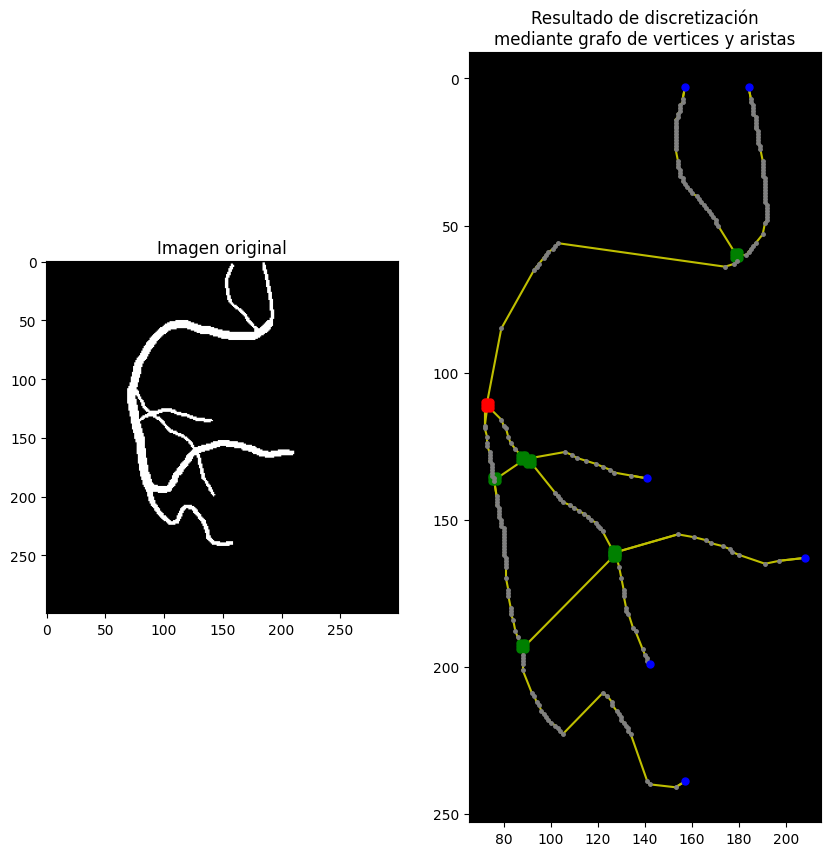

In [317]:
plot_original_Vs_result(*get_image_features('images/1_gt.pgm'))

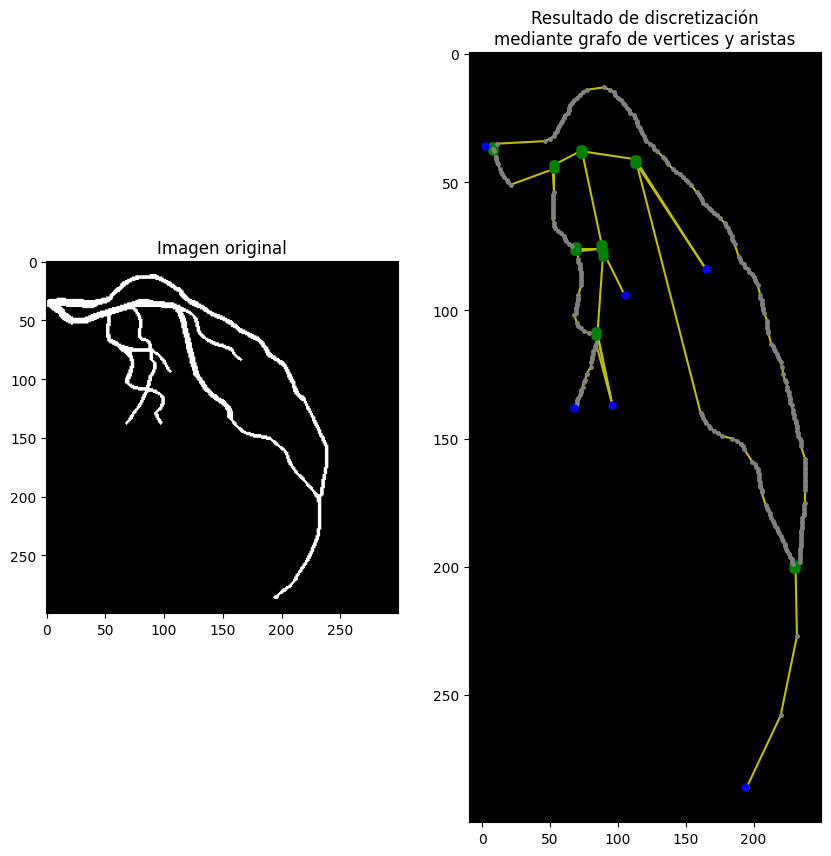

In [318]:
plot_original_Vs_result(*get_image_features('images/2_gt.pgm'))

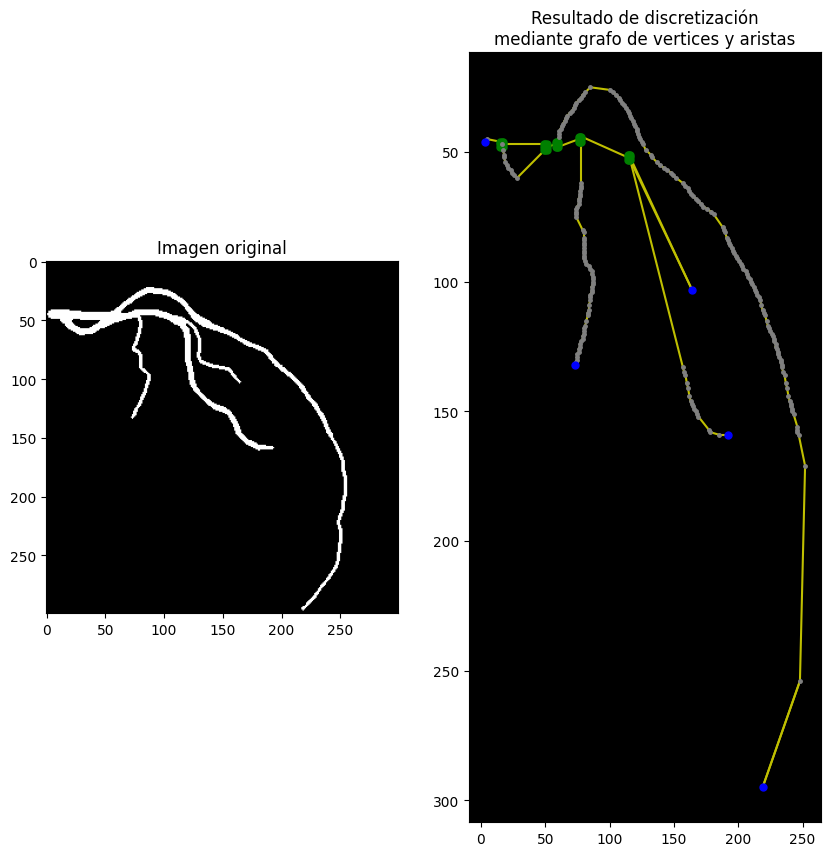

In [319]:
plot_original_Vs_result(*get_image_features('images/3_gt.pgm'))

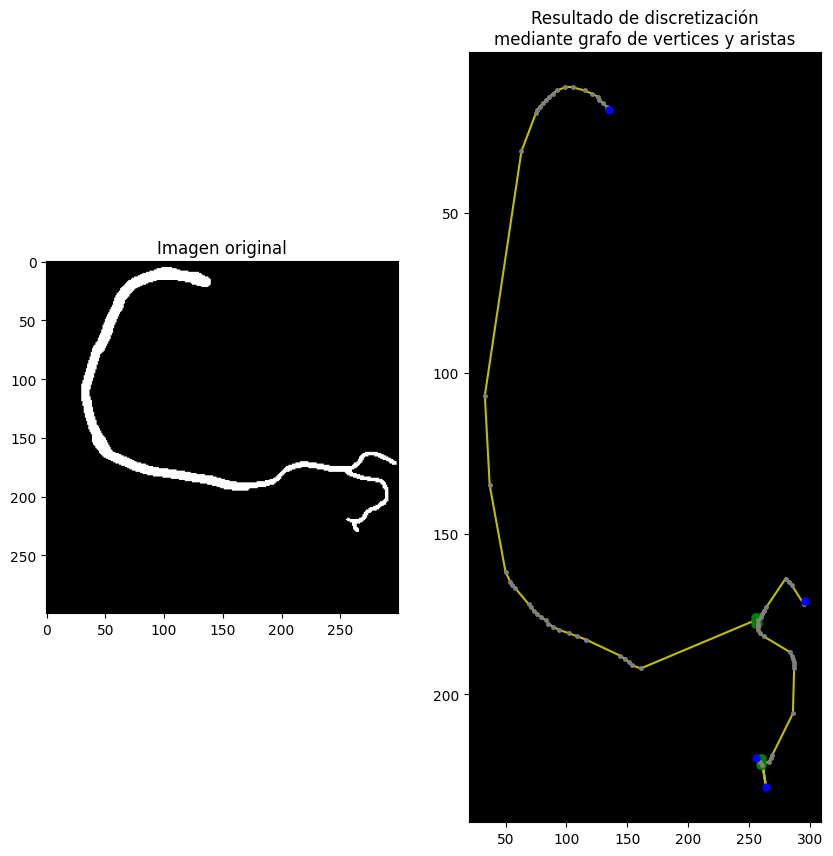

In [320]:
plot_original_Vs_result(*get_image_features('images/4_gt.pgm'))

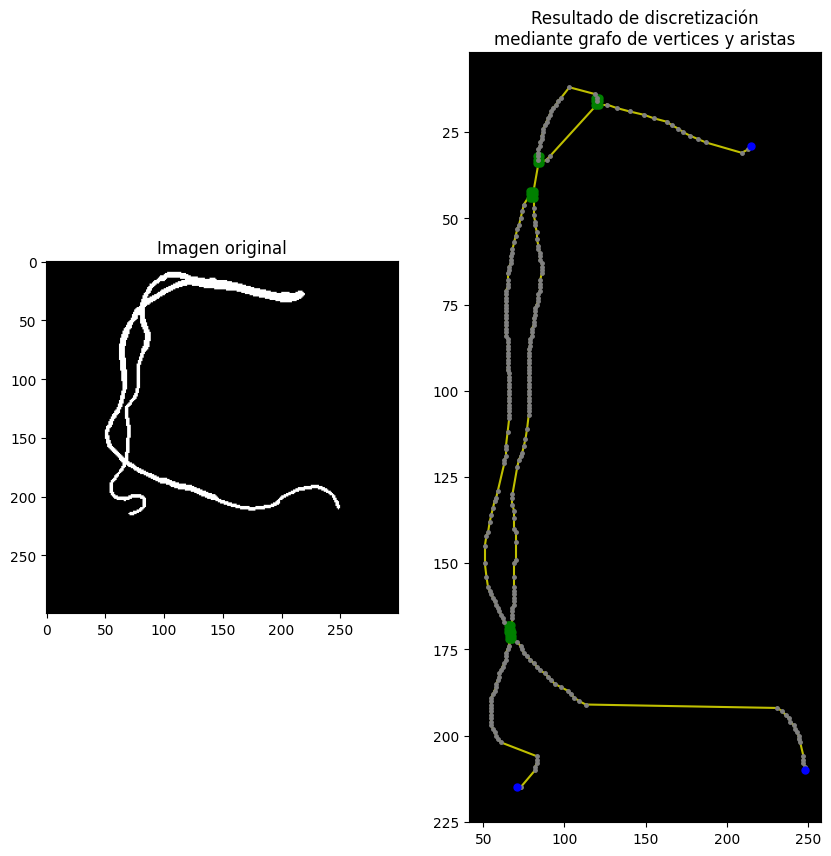

In [321]:
plot_original_Vs_result(*get_image_features('images/5_gt.pgm'))

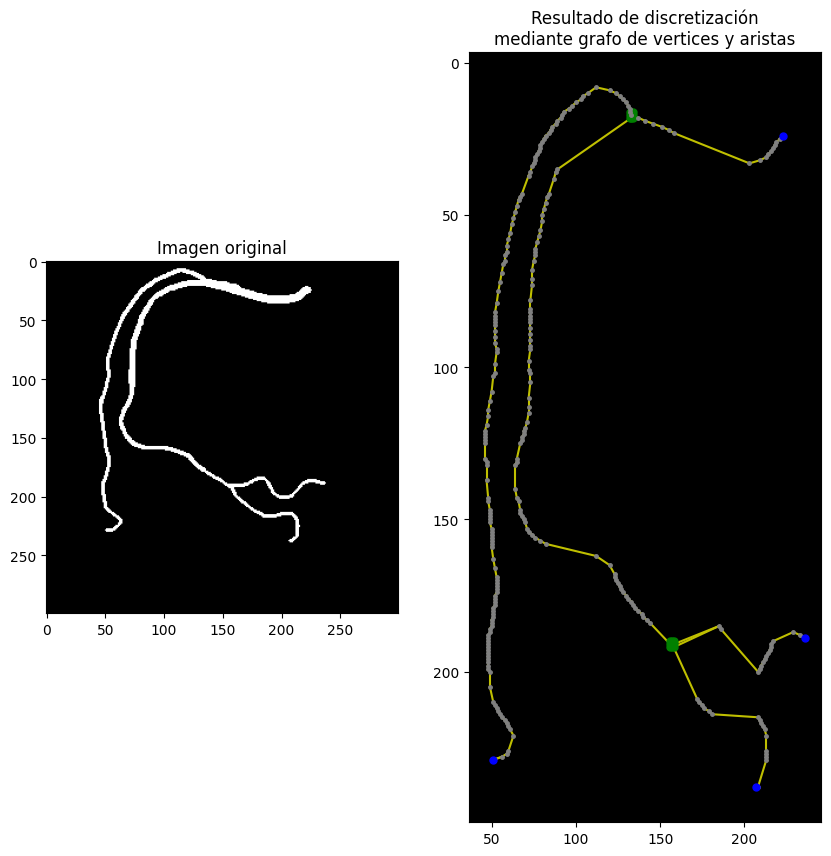

In [322]:
plot_original_Vs_result(*get_image_features('images/6_gt.pgm'))

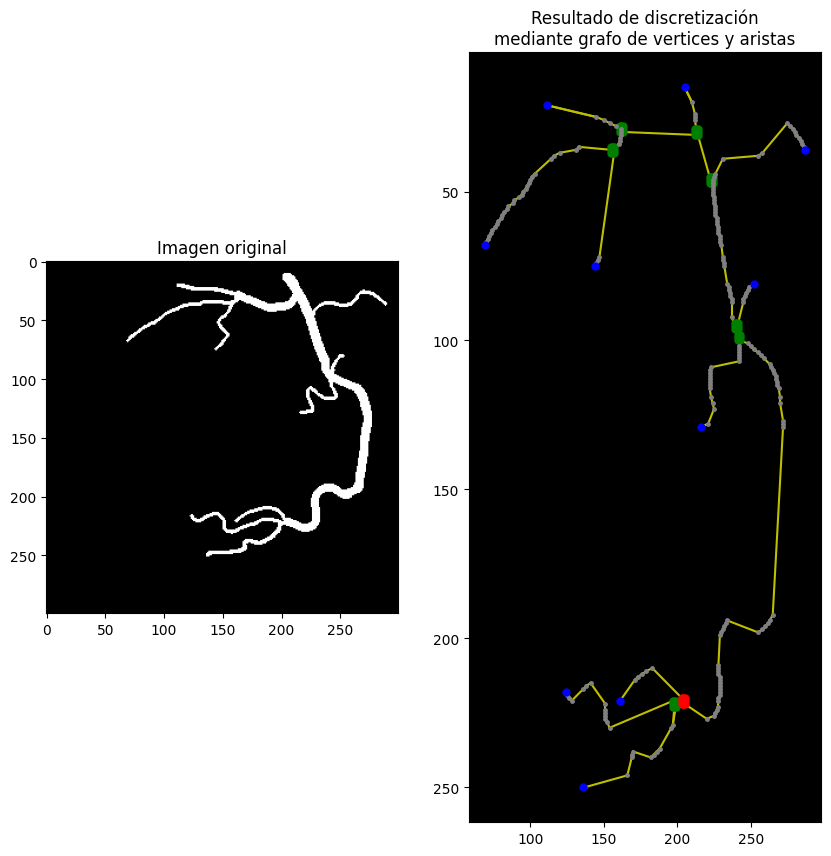

In [323]:
plot_original_Vs_result(*get_image_features('images/7_gt.pgm'))

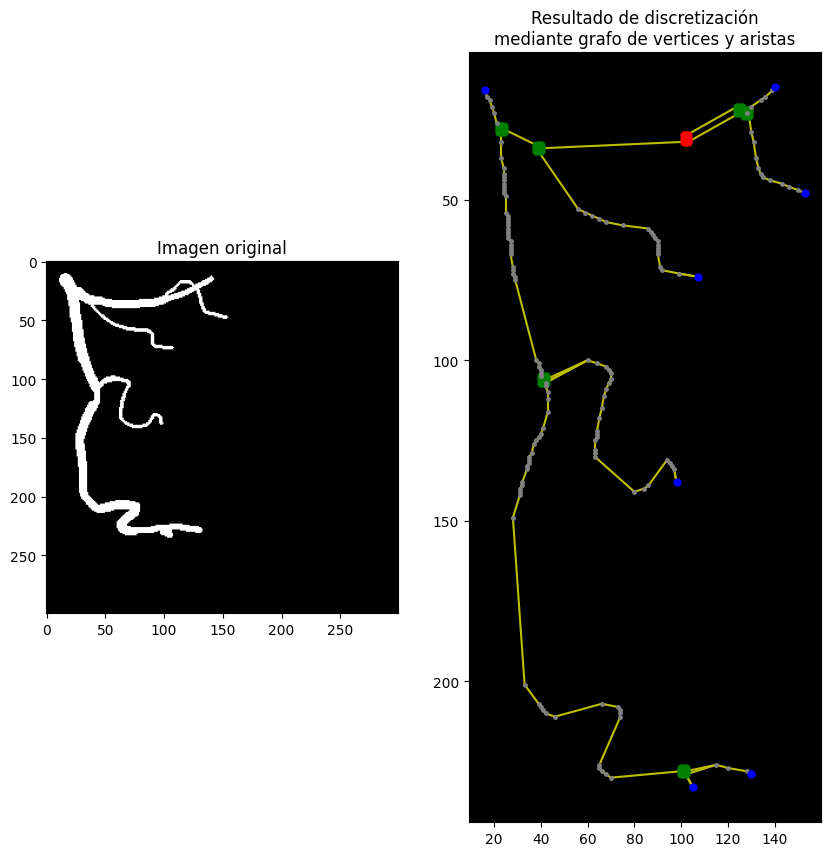

In [324]:
plot_original_Vs_result(*get_image_features('images/8_gt.pgm'))

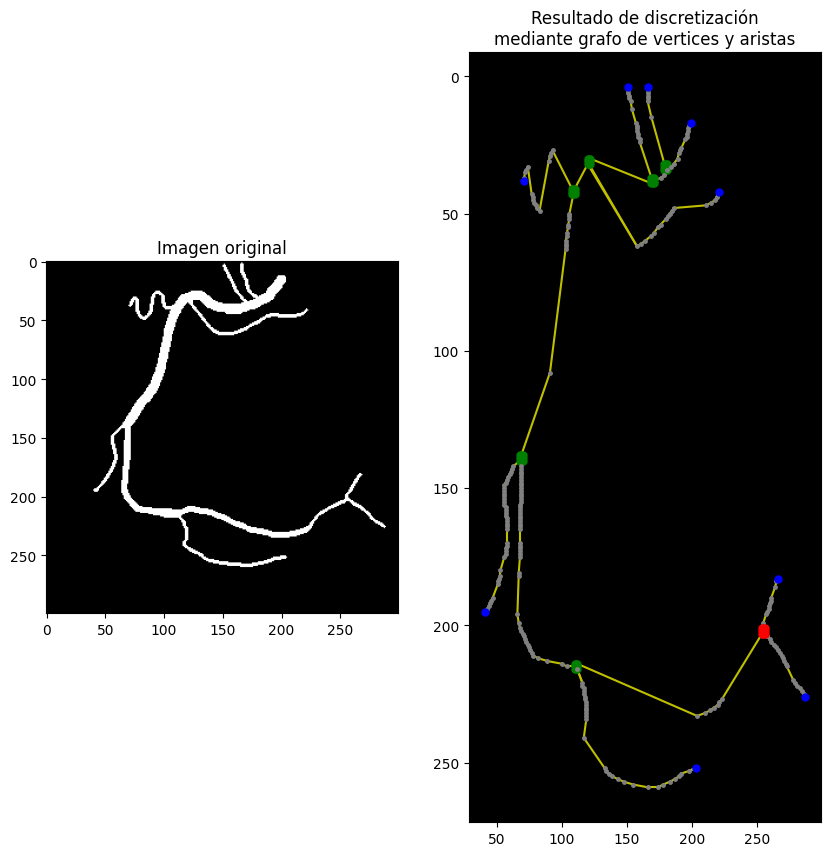

In [325]:
plot_original_Vs_result(*get_image_features('images/9_gt.pgm'))

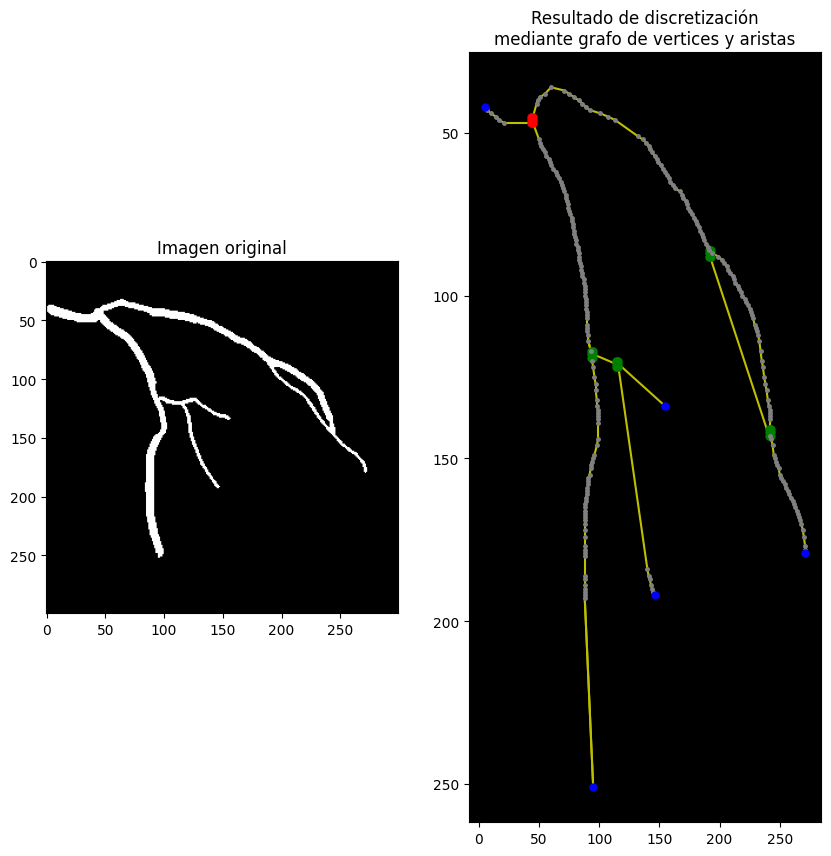

In [326]:
plot_original_Vs_result(*get_image_features('images/10_gt.pgm'))

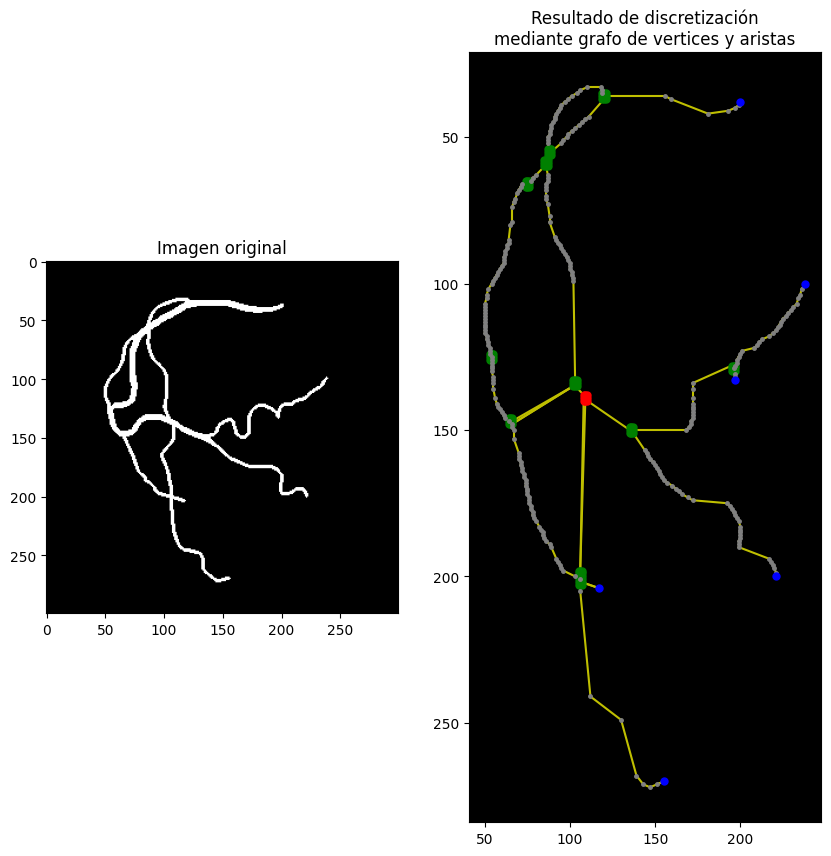

In [327]:
plot_original_Vs_result(*get_image_features('images/11_gt.pgm'))

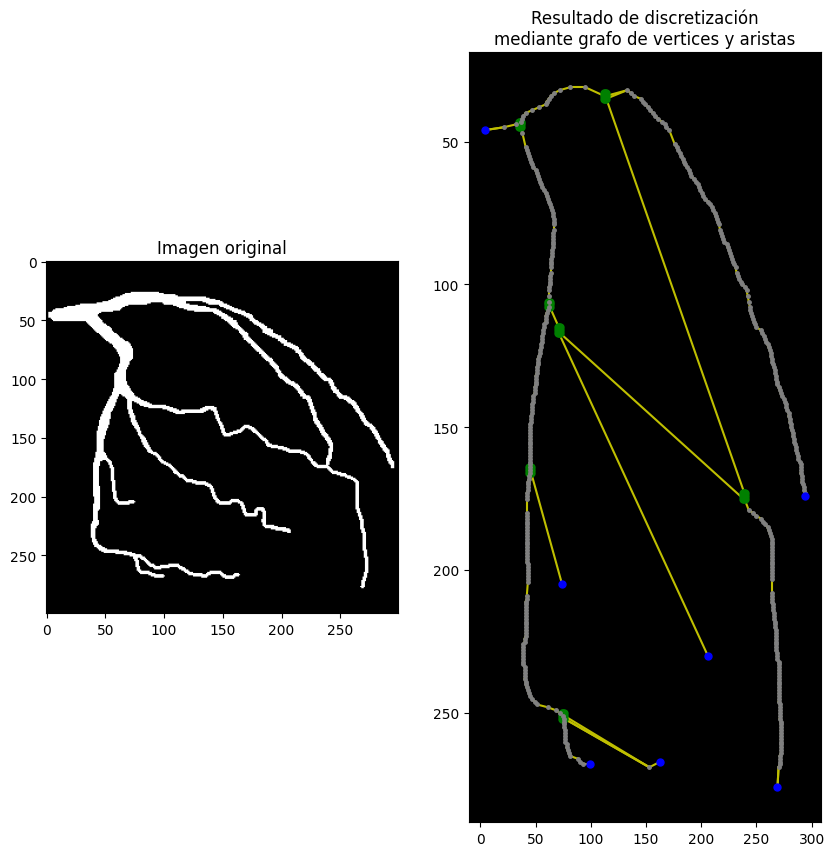

In [328]:
plot_original_Vs_result(*get_image_features('images/12_gt.pgm'))

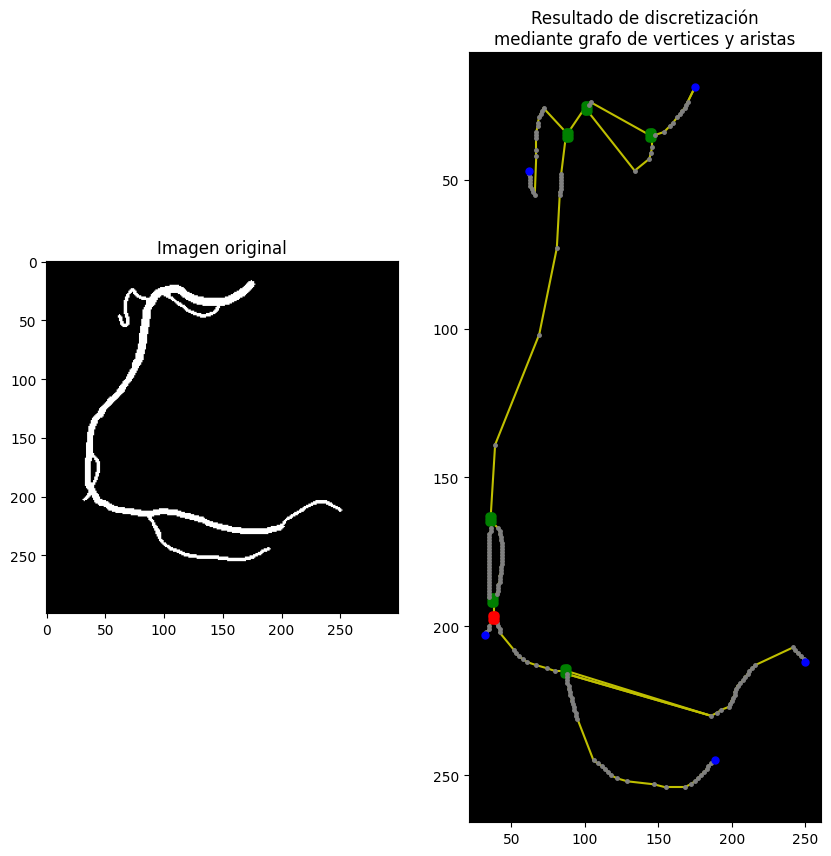

In [329]:
plot_original_Vs_result(*get_image_features('images/13_gt.pgm'))

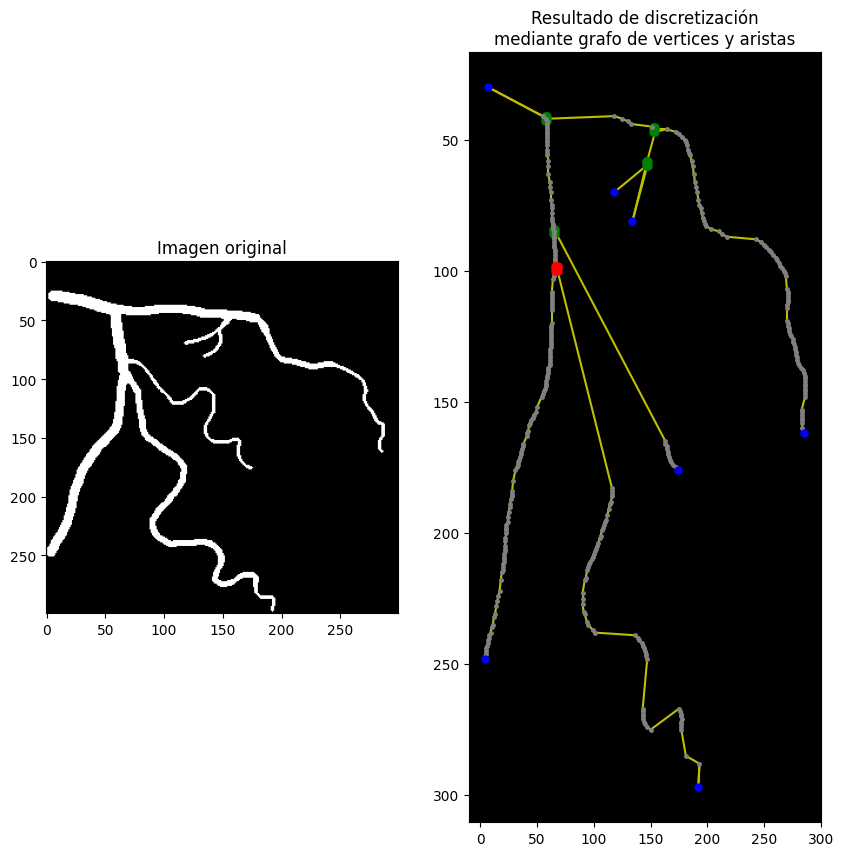

In [330]:
plot_original_Vs_result(*get_image_features('images/14_gt.pgm'))

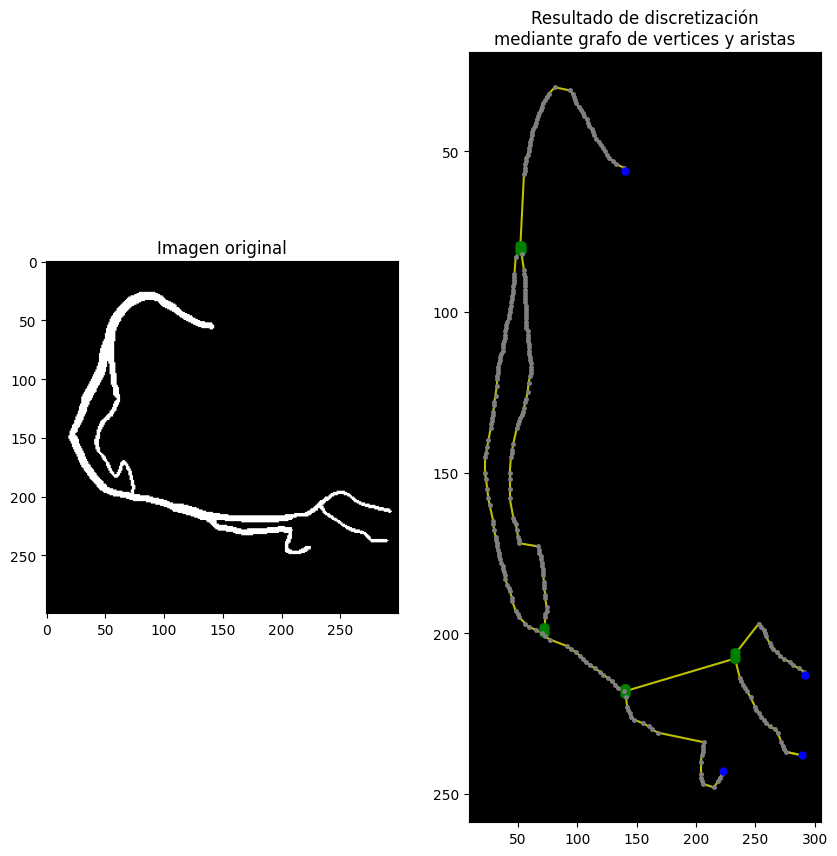

In [331]:
plot_original_Vs_result(*get_image_features('images/15_gt.pgm'))

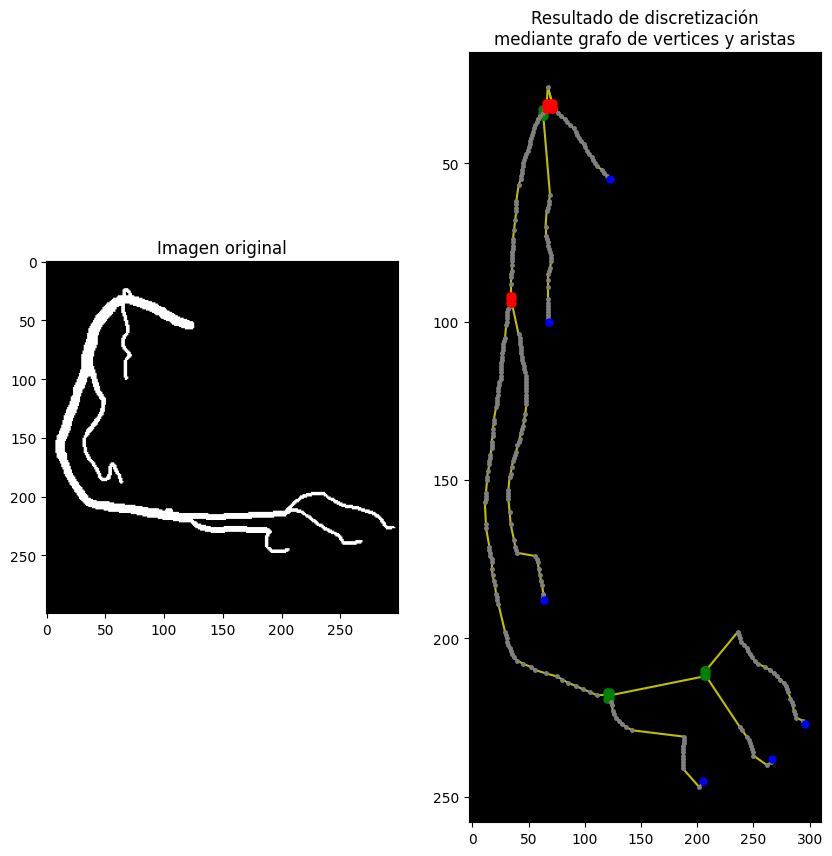

In [332]:
plot_original_Vs_result(*get_image_features('images/16_gt.pgm'))

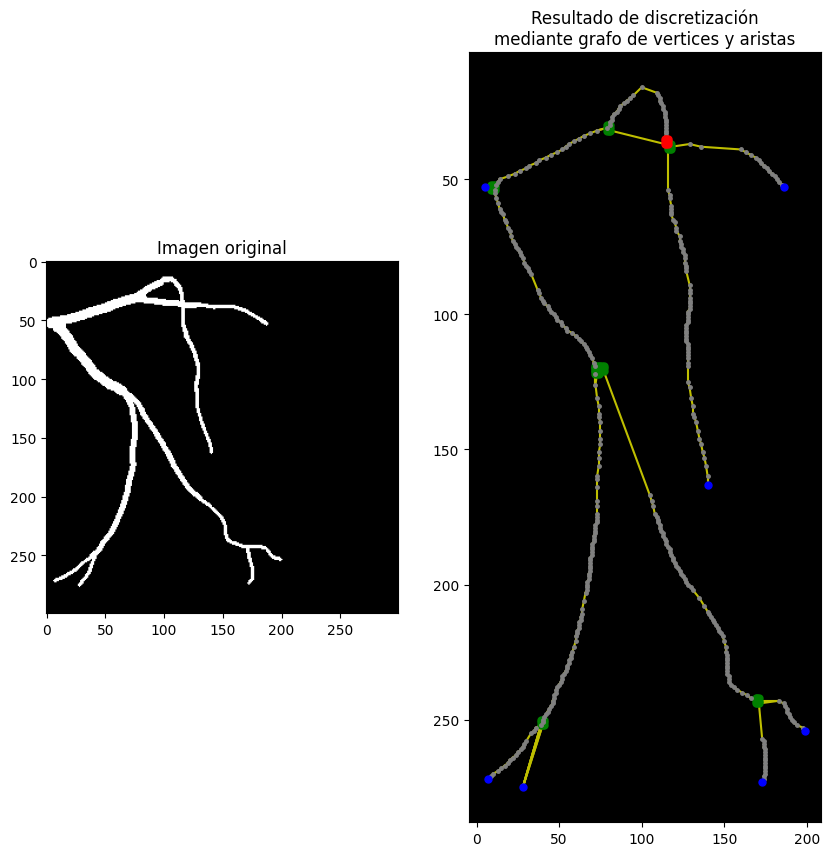

In [333]:
plot_original_Vs_result(*get_image_features('images/17_gt.pgm'))

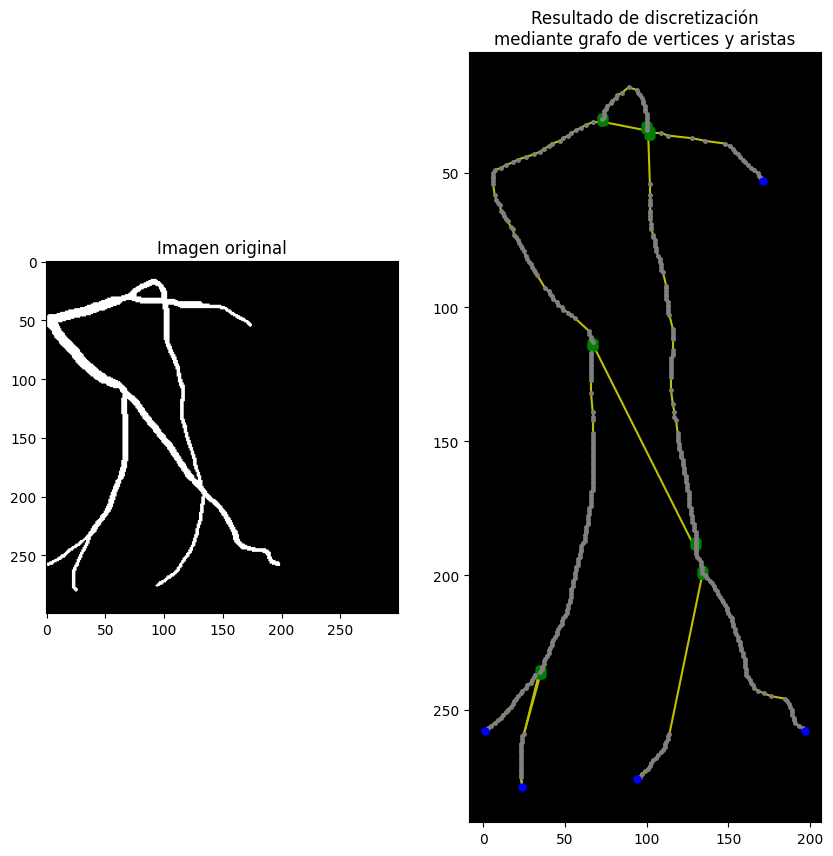

In [334]:
plot_original_Vs_result(*get_image_features('images/18_gt.pgm'))

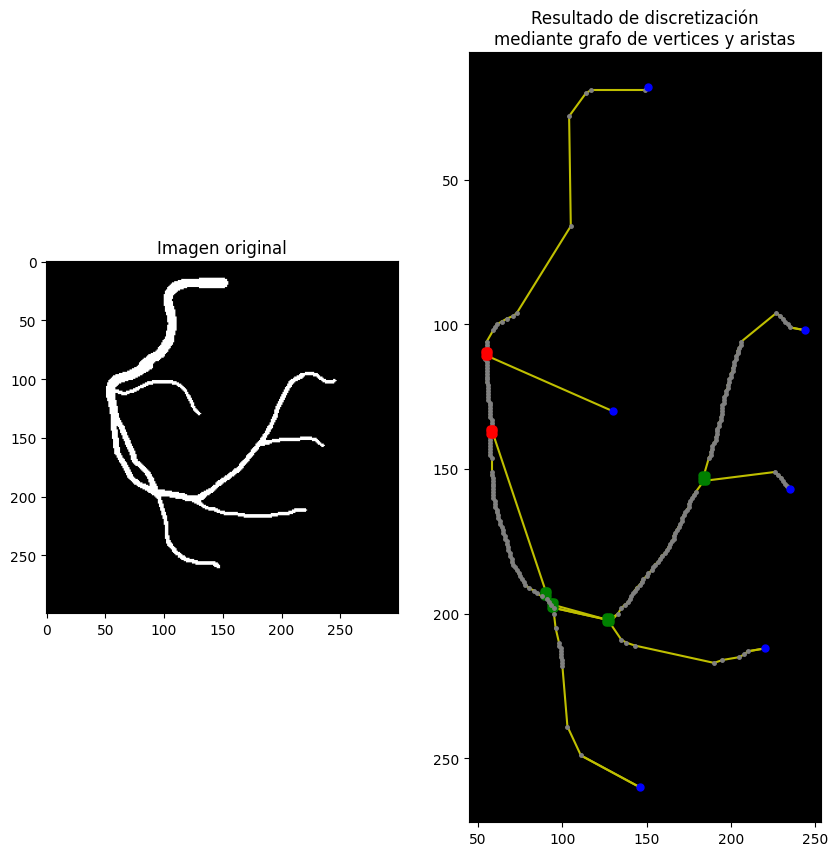

In [335]:
plot_original_Vs_result(*get_image_features('images/19_gt.pgm'))

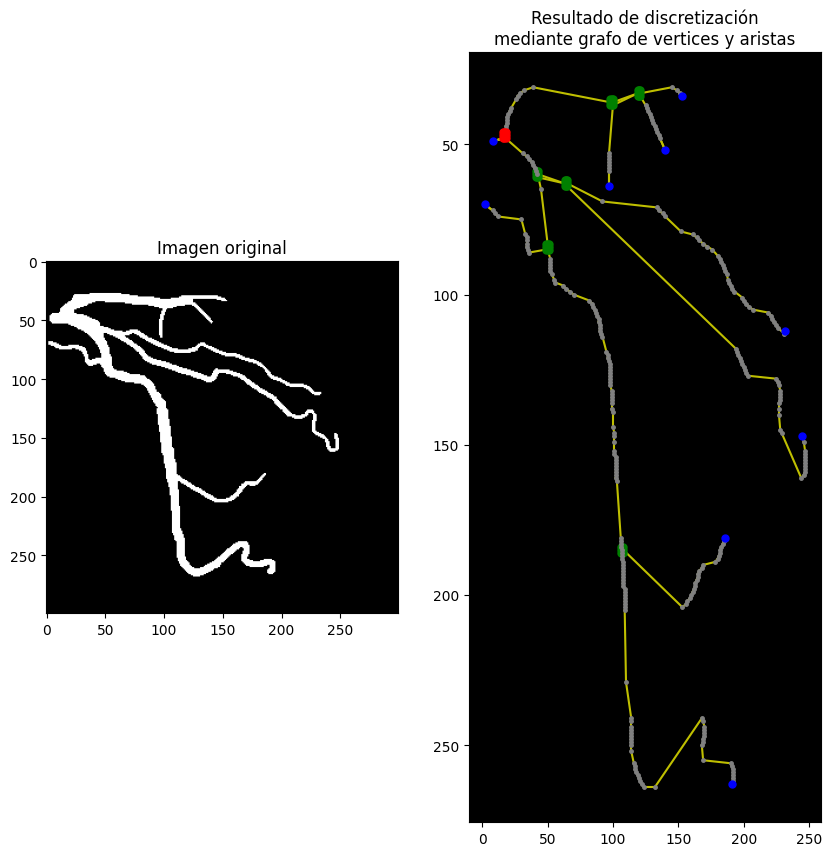

In [336]:
plot_original_Vs_result(*get_image_features('images/20_gt.pgm'))

## Conclusiones

- Utilizar operaciones morfológicas no permitió de esquelitizar de forma adecuada a las figuras, dado que al no tener un grosor uniforme llegaba a romper ciertas partes de las figuras. La función skeletonize, la cual utiliza el algoritmo de thinning de Zhang Suen mostró mejores resultados ya que el propósito del algoritmo es conservar la forma de la figura.
- Utilizar un algoritmo de pathfinding permitió encontrar el camino entre los nodos seleccionados, lo cual permitió construir un grafo representantivo de las imágenes groundtruth.
- El uso de nodos intermedios permite mantener la forma original de la figura.